# Qredo tokenomics simulation - staking rewards parameters

### June 2023

## 1. Imports

In [1]:
import os
import pickle
import pandas as pd
import numpy as np
import itertools
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

In [2]:
forecast_length = 365*2
outfolder = os.path.realpath("../data/sim_data")

## 2. Load and process data

In [3]:
scenario_file = os.path.join(outfolder, f"params_scenarios.pickle")
with open(scenario_file, "rb") as fp:
    scenario_dict_list = pickle.load(fp)
    
n_vals = scenario_dict_list[0]["data_dict_list"][0]["n_validators"]
n_vals_df = pd.DataFrame(index=list(np.arange(forecast_length)))
n_vals_df["n_vals"] = n_vals.astype(int)

In [4]:
# load
df_file = os.path.join(outfolder, f"sample_by_staking_reward_params_and_scenario.pickle")
with open(df_file, "rb") as fp:
    df = pickle.load(fp)

# Add validator count
df = df.join(n_vals_df, on="iteration", how="left")    

# process columns
df["apr"] = 365.0*(df["total_staking_rewards"]-df["validators_rewards"])/df["staking_tvl"]
df["tvl_rate"] = df["staking_tvl"]/df["circ_supply"]
df["validator_reward_share"] = df["validator_reward_share"].round(2)
df["av_validator_reward"] = df["validators_rewards"] / df["n_vals"]
df["staking_rewards_vesting_decay_rate"] = (
    np.where(
        df["staking_rewards_vesting_decay_rate"]==np.log(2) / (4.0 * 365),
        "4yrs half-life",
        "5yrs half-life")
)
df["release_rate_a"] = df["release_rate_a"].round(1)
df["release_rate_fn"] = "a=" + df["release_rate_a"].astype(str) + " b=" + df["release_rate_b"].astype(str)
df["date"] = df["iteration"].apply(lambda x: dt.datetime(2023, 6, 15)+dt.timedelta(days=x)).values

# convert units
mill_cols = ["circ_supply", 'day_vested', 'day_locked', 'day_released',"ecosystem_fund", "staking_tvl"]
df[mill_cols] = df[mill_cols]/(10**6)
thou_cols = ["validators_rewards", 'total_staking_rewards','staking_rewards_vested','staking_rewards_ecosystem']
df[thou_cols] = df[thou_cols]/(10**3)

len(df)

28382400

In [5]:
df.head(1).T

,0
iteration,0
staking_scenario,pessimistic
validator_reward_share,0.1
staking_rewards_vesting_decay_rate,5yrs half-life
release_rate_a,0.3
release_rate_b,0.5
circ_supply,522.293784
day_burned,350000800.0
day_vested,507.0
day_locked,148.705816


## 3. Reward sources

**Notes**

- Staking rewards are slowly deceasing with time
- Rewards coming from the Staking Rewards Fund dominate -> they account for roughly 80% of all rewards
- The scenarios don't have an impact on the rewards vested from the Staking Rewards Fund (as expected!)
- The pessimistic scenario leads to less rewards released from the Ecosystem Fund. This is likely due to the lower TVL, which lowers the release rate -> **Need to check this!!**

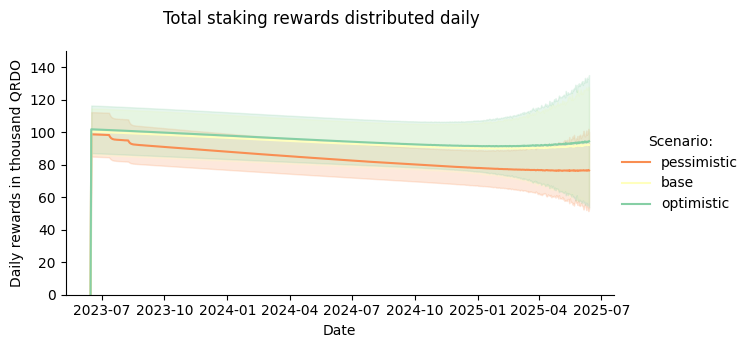

In [6]:
g = sns.relplot(data=df, x="date", y="total_staking_rewards", hue="staking_scenario", 
                kind="line", errorbar="sd", palette="Spectral", height=3.5, aspect=1.5,
                facet_kws={"sharey":False})
(g.set_axis_labels("Date", "Daily rewards in thousand QRDO")
  ._legend.set_title('Scenario:')
)
plt.ylim(0,150)
plt.suptitle("Total staking rewards distributed daily")
plt.tight_layout()
g._legend.set_bbox_to_anchor([1.15, 0.5])
plt.show()

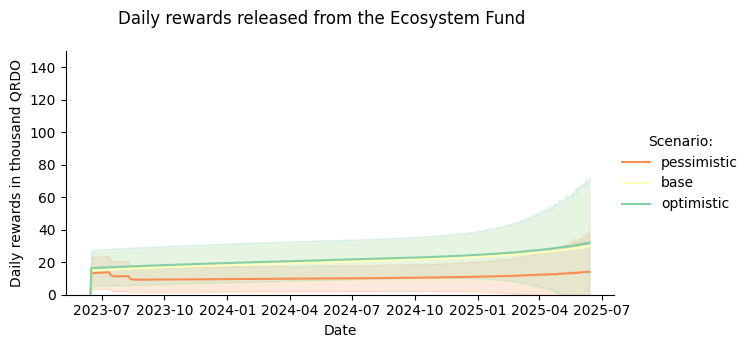

In [7]:
g = sns.relplot(data=df, x="date", y="staking_rewards_ecosystem", hue="staking_scenario", 
                kind="line", errorbar="sd", palette="Spectral", height=3.5, aspect=1.5,
                facet_kws={"sharey":False})
(g.set_axis_labels("Date", "Daily rewards in thousand QRDO")
  ._legend.set_title('Scenario:')
)
plt.ylim(0,150)
plt.suptitle("Daily rewards released from the Ecosystem Fund")
plt.tight_layout()
g._legend.set_bbox_to_anchor([1.15, 0.5])
plt.show()

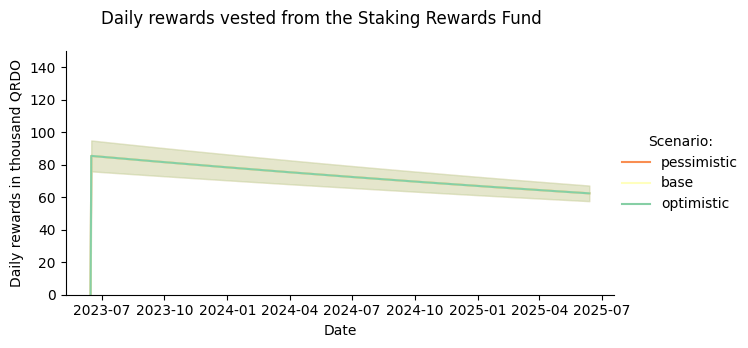

In [8]:
g = sns.relplot(data=df, x="date", y="staking_rewards_vested", hue="staking_scenario", 
                kind="line", errorbar="sd", palette="Spectral", height=3.5, aspect=1.5,
                facet_kws={"sharey":False})
(g.set_axis_labels("Date", "Daily rewards in thousand QRDO")
  ._legend.set_title('Scenario:')
)
plt.ylim(0,150)
plt.suptitle("Daily rewards vested from the Staking Rewards Fund")
plt.tight_layout()
g._legend.set_bbox_to_anchor([1.15, 0.5])
plt.show()

## 4. Parameter analysis - Validator reward share

**Notes**

- Lower validator reward shares leads to higher APR's for Stakers (duh!). For instance, in the base scenario, the different is on average 8 percentual points
- A validator reward share of 40% leads to a daily reward per validators between 7k and 5k QRDO. At the current token price, this a monthly USD reward of 2.1k - 1.5k -> this seems too low!!
    - **Possible idea here:** have a validator share rate of 60% - 80% and increase the ecosystem fund at the expense of the validator rewards funds (so that rewards growth with the number of validators)

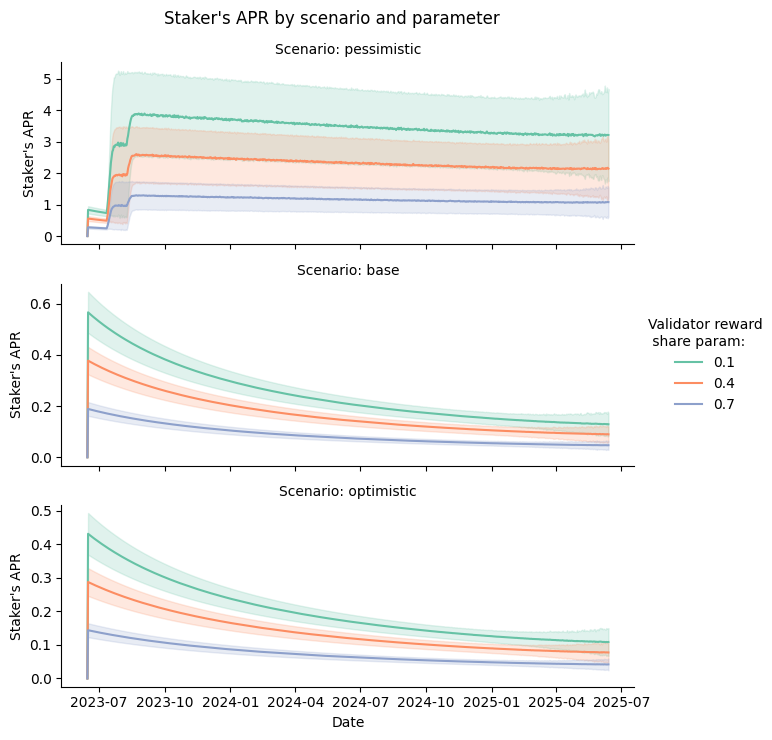

In [9]:
g = sns.relplot(data=df, x="date", y="apr", hue="validator_reward_share", row="staking_scenario", 
                kind="line", errorbar="sd", palette="Set2", height=2.5, aspect=2,
                facet_kws={"sharey":False})
(g.set_axis_labels("Date", "Staker's APR")
  .set_titles("Scenario: {row_name}")
  ._legend.set_title('Validator reward\n share param:')
)
plt.suptitle("Staker's APR by scenario and parameter")
plt.tight_layout()
g._legend.set_bbox_to_anchor([1.15, 0.5])
plt.show()

In [10]:
temp_df = df[df["staking_scenario"]=="base"].groupby("validator_reward_share")["apr"].mean()
print(temp_df)
print(temp_df.diff())

validator_reward_share
0.1    0.246524
0.4    0.168712
0.7    0.086683
Name: apr, dtype: float64
validator_reward_share
0.1         NaN
0.4   -0.077811
0.7   -0.082029
Name: apr, dtype: float64


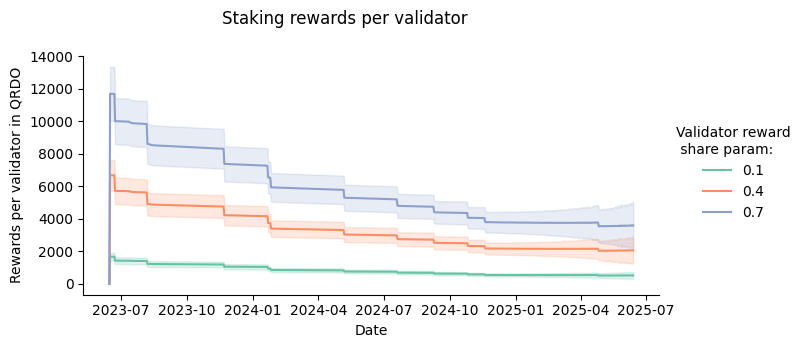

In [11]:
g = sns.relplot(data=df, x="date", y="av_validator_reward", hue="validator_reward_share",
                kind="line", errorbar="sd", palette="Set2",   height=3.5, aspect=1.5,
                facet_kws={"sharey":False})
(g.set_axis_labels("Date", "Rewards per validator in QRDO")
  ._legend.set_title('Validator reward\n share param:')
)
plt.suptitle("Staking rewards per validator")
plt.tight_layout()
g._legend.set_bbox_to_anchor([1.15, 0.5])
plt.show()

## 5. Parameter analysis - vesting decay rate

**Notes**

- Maybe we should set the release based on a target TVL and APR?

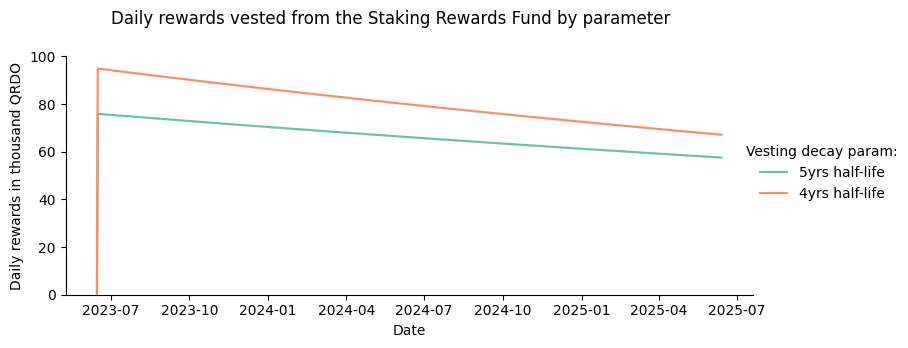

In [12]:
g = sns.relplot(data=df, x="date", y="staking_rewards_vested", hue="staking_rewards_vesting_decay_rate", 
                kind="line", errorbar="sd", palette="Set2", height=3.5, aspect=1.5,
                facet_kws={"sharey":False})
(g.set_axis_labels("Date", "Daily rewards in thousand QRDO")
  ._legend.set_title('Vesting decay param:')
)
plt.suptitle("Daily rewards vested from the Staking Rewards Fund by parameter")
plt.ylim(0,100)
plt.tight_layout()
g._legend.set_bbox_to_anchor([1.15, 0.5])
plt.show()

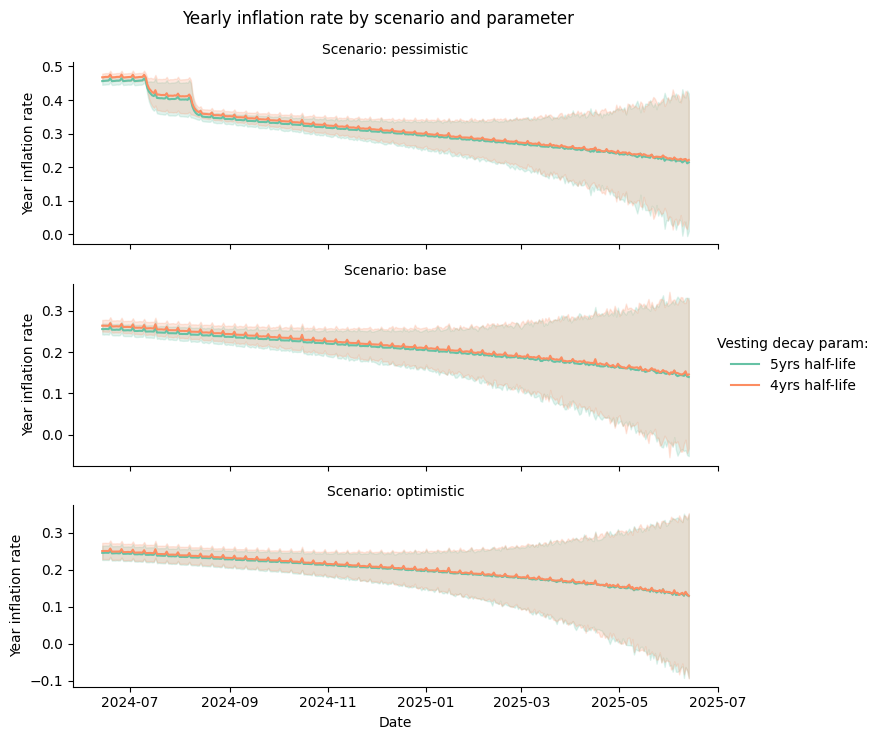

In [13]:
g = sns.relplot(data=df, x="date", y="year_inflation", hue="staking_rewards_vesting_decay_rate", row="staking_scenario", 
                kind="line", errorbar="sd", palette="Set2", height=2.5, aspect=2,
                facet_kws={"sharey":False})
(g.set_axis_labels("Date", "Year inflation rate")
  .set_titles("Scenario: {row_name}")
  ._legend.set_title('Vesting decay param:')
)
plt.suptitle("Yearly inflation rate by scenario and parameter")
plt.tight_layout()
g._legend.set_bbox_to_anchor([1.15, 0.5])
plt.show()

In [14]:
temp_df = df[df["staking_scenario"]=="base"].groupby("staking_rewards_vesting_decay_rate")["year_inflation"].mean()
print(temp_df)

staking_rewards_vesting_decay_rate
4yrs half-life    0.212397
5yrs half-life    0.206901
Name: year_inflation, dtype: float64


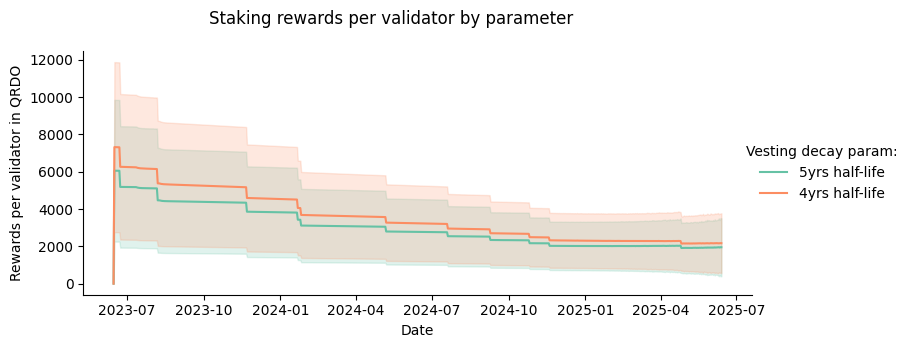

In [15]:
g = sns.relplot(data=df, x="date", y="av_validator_reward", hue="staking_rewards_vesting_decay_rate",
                kind="line", errorbar="sd", palette="Set2",   height=3.5, aspect=1.5,
                facet_kws={"sharey":False})
(g.set_axis_labels("Date", "Rewards per validator in QRDO")
  ._legend.set_title('Vesting decay param:')
)
plt.suptitle("Staking rewards per validator by parameter")
plt.tight_layout()
g._legend.set_bbox_to_anchor([1.15, 0.5])
plt.show()

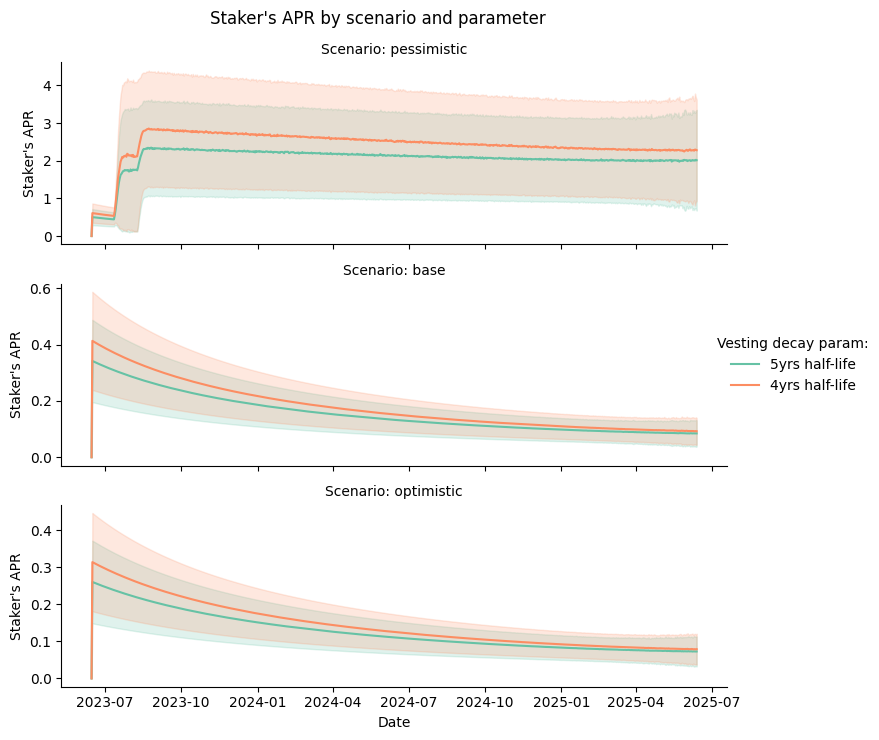

In [16]:
g = sns.relplot(data=df, x="date", y="apr", hue="staking_rewards_vesting_decay_rate", row="staking_scenario", 
                kind="line", errorbar="sd", palette="Set2", height=2.5, aspect=2,
                facet_kws={"sharey":False})
(g.set_axis_labels("Date", "Staker's APR")
  .set_titles("Scenario: {row_name}")
  ._legend.set_title('Vesting decay param:')
)
plt.suptitle("Staker's APR by scenario and parameter")
plt.tight_layout()
g._legend.set_bbox_to_anchor([1.15, 0.5])
plt.show()

## 6. Parameter analysis - release rate function

- Change in no. validators is not leading to a significant chnage in the release rate -> this is because of the different scales in the TVL and no. of validators variables -> **solution:** scale the release function to take TVL in tens of million QRDO
- If we implement scale adjustment, there is no clear advange to have the parameter `b` different from 1. In other words, we have giving similiar weight to TVL and the no. of validators.
- As for the parameter `a`, there are two main choices:
    1. Have a sublinear function, which gives higher rates to lower values of either TVL or validator count. This function has the advantage of rewarding early adopters as the rewards per participant are expected to decrease as more participants join.
    2. Keep the release function linear, with the release rate increasing proportionally with either TVL or validator count. This option is better when we analyse the rewards per validator or per TVL. With a linear function, there is more incentive for collaboration since the rewards per participant do not decrease as much with increasing TVL or validator count. Adding to the fact that the vesting of the staking rewards fund already decreases an adavnatge to early adoptors, **we propose to have a linear function here**.
- There is a small issue with the function where the max release rate can go over the predefined 0.008 if wither the validator count or the TVL goes over 50 and 1.4B respectively. -> is this a concern?? We can manually cap it!

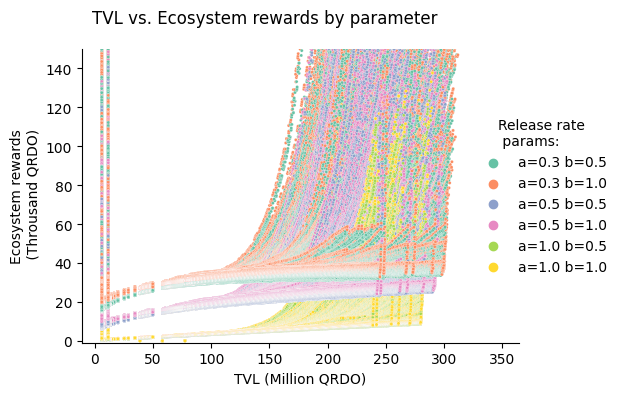

In [17]:
g = sns.relplot(data=df, x="staking_tvl", y="staking_rewards_ecosystem", hue="release_rate_fn",
                kind="scatter", palette="Set2", height=4, aspect=1, s=5)
(g.set_axis_labels("TVL (Million QRDO)", "Ecosystem rewards\n (Throusand QRDO)")
  ._legend.set_title('Release rate \n params:')
)
plt.suptitle("TVL vs. Ecosystem rewards by parameter")
plt.ylim(-1,150)
plt.tight_layout()
g._legend.set_bbox_to_anchor([1.15, 0.5])
plt.show()

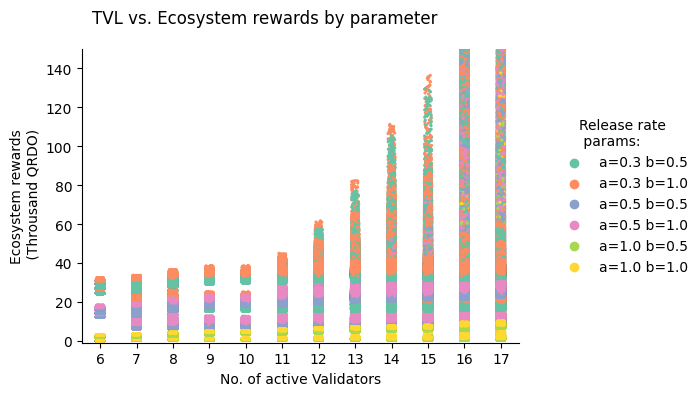

In [18]:
g = sns.catplot(data=df, x="n_vals", y="staking_rewards_ecosystem", hue="release_rate_fn",
                kind="strip", palette="Set2", height=4, aspect=1, s=5)
(g.set_axis_labels("No. of active Validators", "Ecosystem rewards\n (Throusand QRDO)")
  ._legend.set_title('Release rate \n params:')
)
plt.suptitle("TVL vs. Ecosystem rewards by parameter")
plt.ylim(-1,150)
plt.tight_layout()
g._legend.set_bbox_to_anchor([1.3, 0.5])
plt.show()

### Release function parameter space

In [19]:
def fractional_power(tvl_millions, n_val, a, b, unit_scale=1):
    T_max = 50
    V_max = (2000 * 0.7)/unit_scale #-> should this be 0.5???
    max_rate = 0.0008
    tvl = tvl_millions/unit_scale
    r = (tvl**a + b * n_val**a) / (T_max**a + b * V_max**a)
    return max_rate * r

a_list = [1/3, 1/2, 1.0]
b_list = [0.5, 1.0]
x = np.arange(50, 305, 5) # TVL
y = np.arange(6, 19, 1) # Validators
xx, yy = np.meshgrid(x, y)

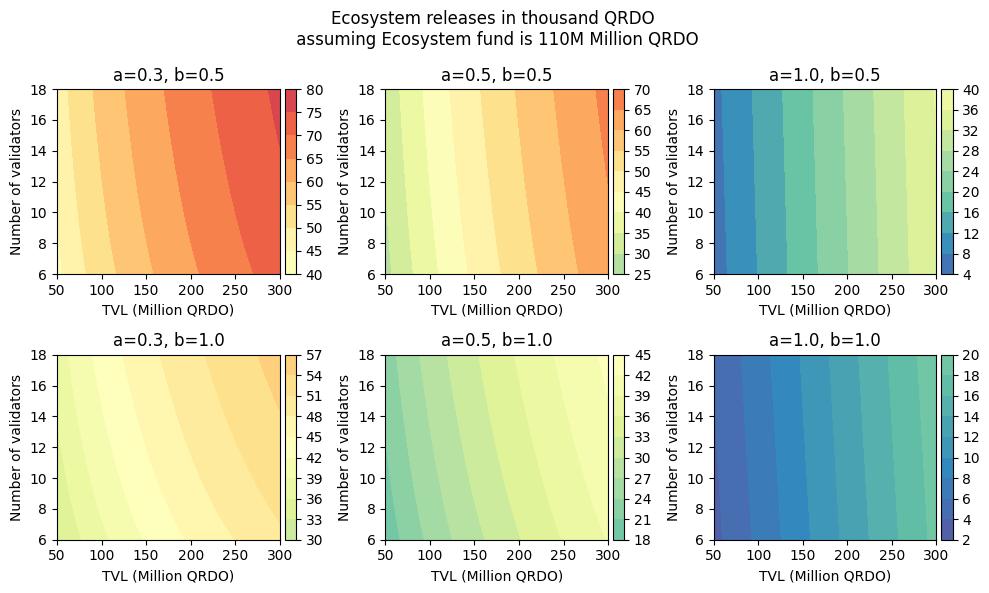

In [20]:
fig, axs = plt.subplots(2, 3, figsize=(10,6))
for col, a in enumerate(a_list):
    for row, b in enumerate(b_list):
        zz = fractional_power(xx, yy, a, b) * 110_000
        p = axs[row, col].contourf(x, y, zz, vmin=0, vmax=0.0008*110_000, cmap="Spectral_r")
        divider = make_axes_locatable(axs[row, col])
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(p, cax=cax, orientation='vertical')
        axs[row, col].set_ylabel('Number of validators')
        axs[row, col].set_xlabel('TVL (Million QRDO)')
        axs[row, col].set_title(f'a={np.round(a, 1)}, b={b}')
plt.suptitle('Ecosystem releases in thousand QRDO \n assuming Ecosystem fund is 110M Million QRDO')
plt.tight_layout()
plt.show()

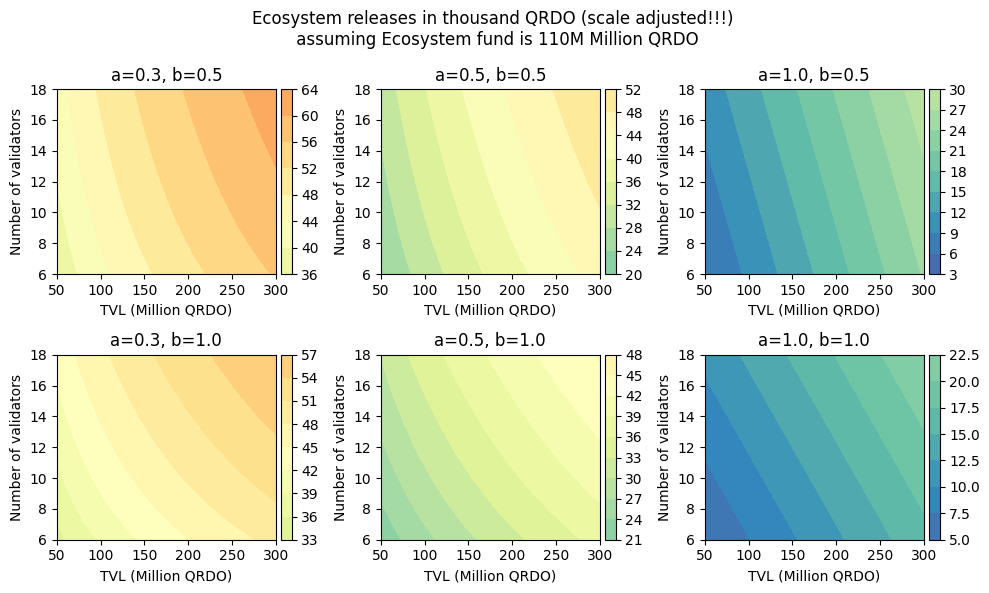

In [21]:
fig, axs = plt.subplots(2, 3, figsize=(10,6))
for col, a in enumerate(a_list):
    for row, b in enumerate(b_list):
        zz = fractional_power(xx, yy, a, b, 10) * 110_000
        p = axs[row, col].contourf(x, y, zz, vmin=0, vmax=0.0008*110_000, cmap="Spectral_r")
        divider = make_axes_locatable(axs[row, col])
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(p, cax=cax, orientation='vertical')
        axs[row, col].set_ylabel('Number of validators')
        axs[row, col].set_xlabel('TVL (Million QRDO)')
        axs[row, col].set_title(f'a={np.round(a, 1)}, b={b}')

plt.suptitle('Ecosystem releases in thousand QRDO (scale adjusted!!!) \n assuming Ecosystem fund is 110M Million QRDO')
plt.tight_layout()
plt.show()

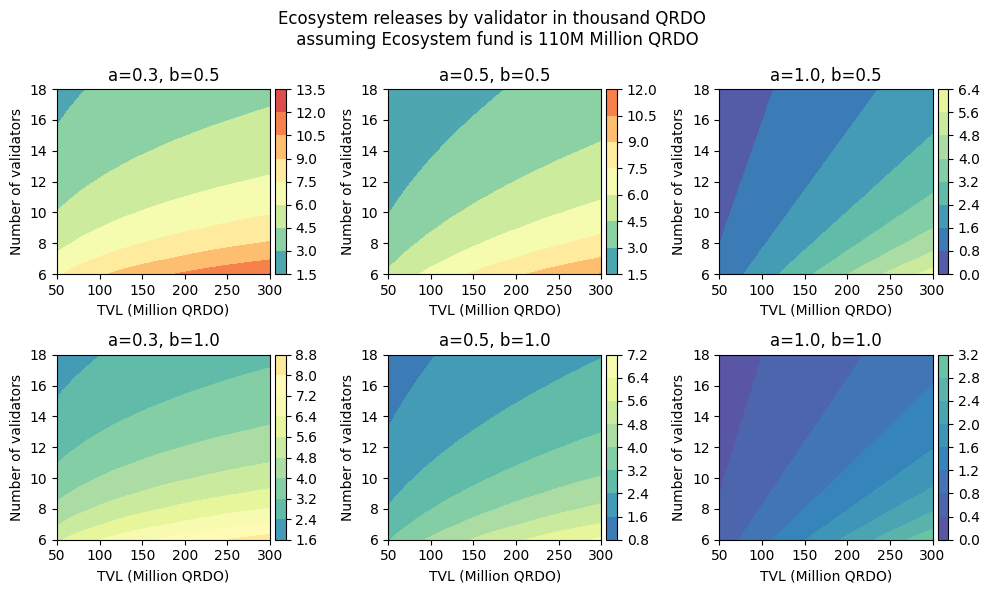

In [22]:
fig, axs = plt.subplots(2, 3, figsize=(10,6))
for col, a in enumerate(a_list):
    for row, b in enumerate(b_list):
        zz = fractional_power(xx, yy, a, b) * 110_000 / yy
        p = axs[row, col].contourf(x, y, zz, vmin=0, vmax=0.0008*110_000/6, cmap="Spectral_r")
        divider = make_axes_locatable(axs[row, col])
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(p, cax=cax, orientation='vertical')
        axs[row, col].set_ylabel('Number of validators')
        axs[row, col].set_xlabel('TVL (Million QRDO)')
        axs[row, col].set_title(f'a={np.round(a, 1)}, b={b}')
plt.suptitle('Ecosystem releases by validator in thousand QRDO \n assuming Ecosystem fund is 110M Million QRDO')
plt.tight_layout()
plt.show()

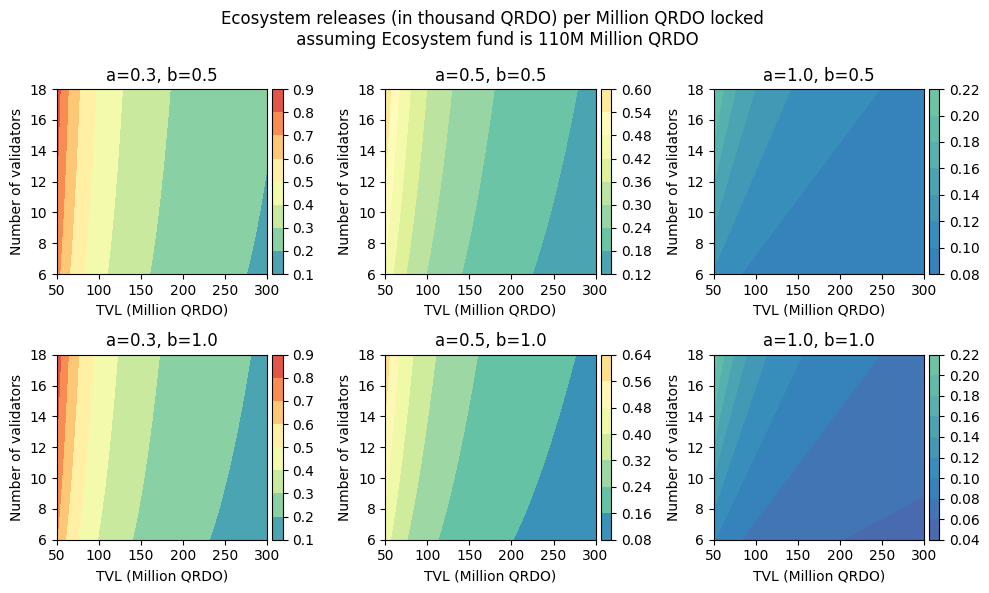

In [23]:
fig, axs = plt.subplots(2, 3, figsize=(10,6))
for col, a in enumerate(a_list):
    for row, b in enumerate(b_list):
        zz = (fractional_power(xx, yy, a, b, 10) * 110_000) / xx
        p = axs[row, col].contourf(x, y, zz, vmin=0, vmax=1, cmap="Spectral_r")
        divider = make_axes_locatable(axs[row, col])
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(p, cax=cax, orientation='vertical')
        axs[row, col].set_ylabel('Number of validators')
        axs[row, col].set_xlabel('TVL (Million QRDO)')
        axs[row, col].set_title(f'a={np.round(a, 1)}, b={b}')
plt.suptitle('Ecosystem releases (in thousand QRDO) per Million QRDO locked \n assuming Ecosystem fund is 110M Million QRDO')
plt.tight_layout()
plt.show()

## Extra

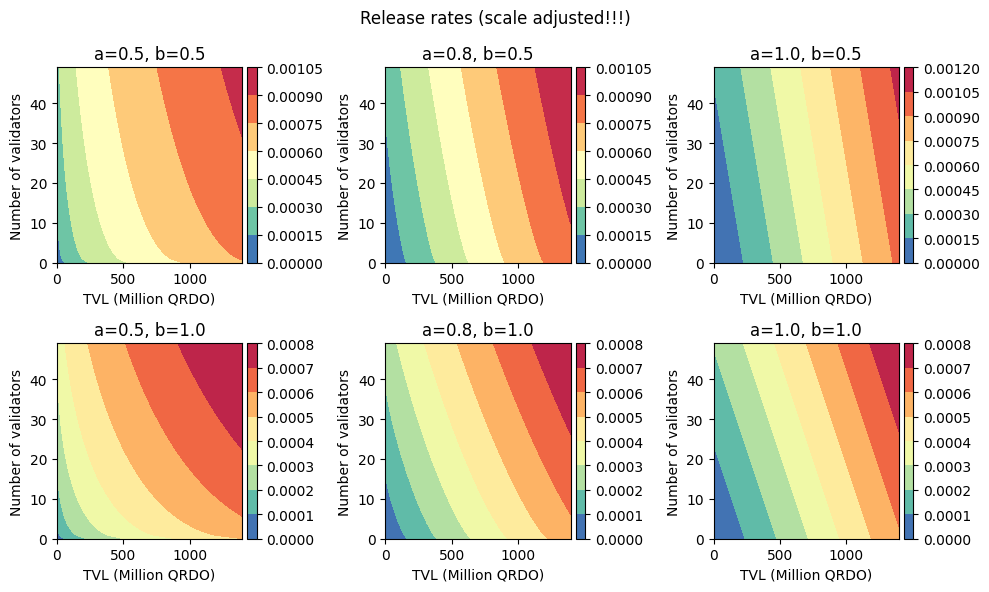

In [24]:
a_list = [0.5, 0.8, 1.0]
b_list = [0.5, 1.0]
x = np.arange(0, 2000 * 0.7, 5) # TVL
y = np.arange(0, 50, 1) # Validators
xx, yy = np.meshgrid(x, y)

fig, axs = plt.subplots(2, 3, figsize=(10,6))
for col, a in enumerate(a_list):
    for row, b in enumerate(b_list):
        zz = fractional_power(xx, yy, a, b, 10)
        p = axs[row, col].contourf(x, y, zz, cmap="Spectral_r")
        divider = make_axes_locatable(axs[row, col])
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(p, cax=cax, orientation='vertical')
        axs[row, col].set_ylabel('Number of validators')
        axs[row, col].set_xlabel('TVL (Million QRDO)')
        axs[row, col].set_title(f'a={np.round(a, 1)}, b={b}')

plt.suptitle('Release rates (scale adjusted!!!)')
plt.tight_layout()
plt.show()

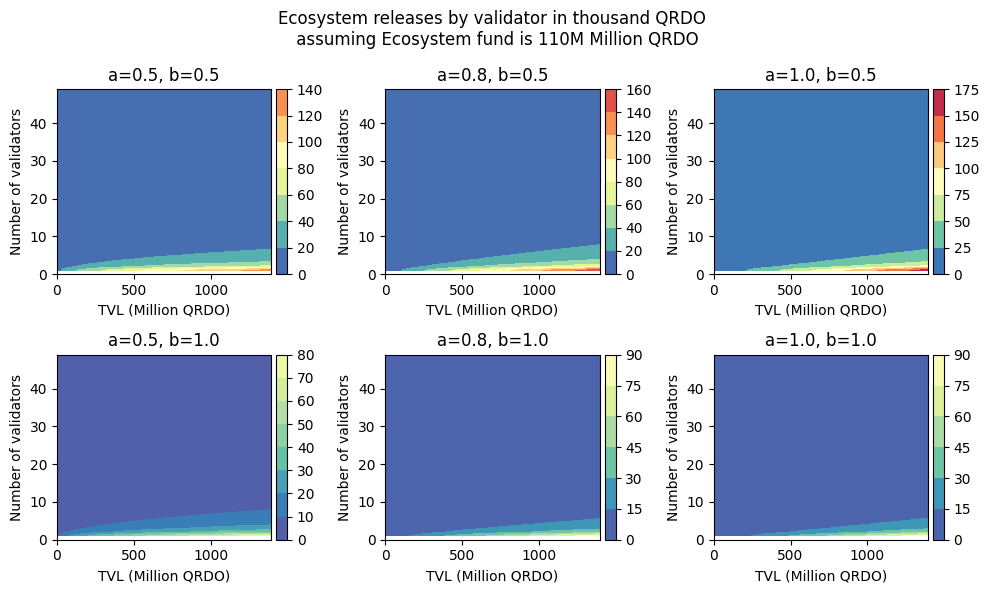

In [25]:
fig, axs = plt.subplots(2, 3, figsize=(10,6))
for col, a in enumerate(a_list):
    for row, b in enumerate(b_list):
        zz = fractional_power(xx, yy, a, b) * 110_000 / yy
        p = axs[row, col].contourf(x, y, zz, vmin=0, vmax=175, cmap="Spectral_r")
        divider = make_axes_locatable(axs[row, col])
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(p, cax=cax, orientation='vertical')
        axs[row, col].set_ylabel('Number of validators')
        axs[row, col].set_xlabel('TVL (Million QRDO)')
        axs[row, col].set_title(f'a={np.round(a, 1)}, b={b}')
plt.suptitle('Ecosystem releases by validator in thousand QRDO \n assuming Ecosystem fund is 110M Million QRDO')
plt.tight_layout()
plt.show()

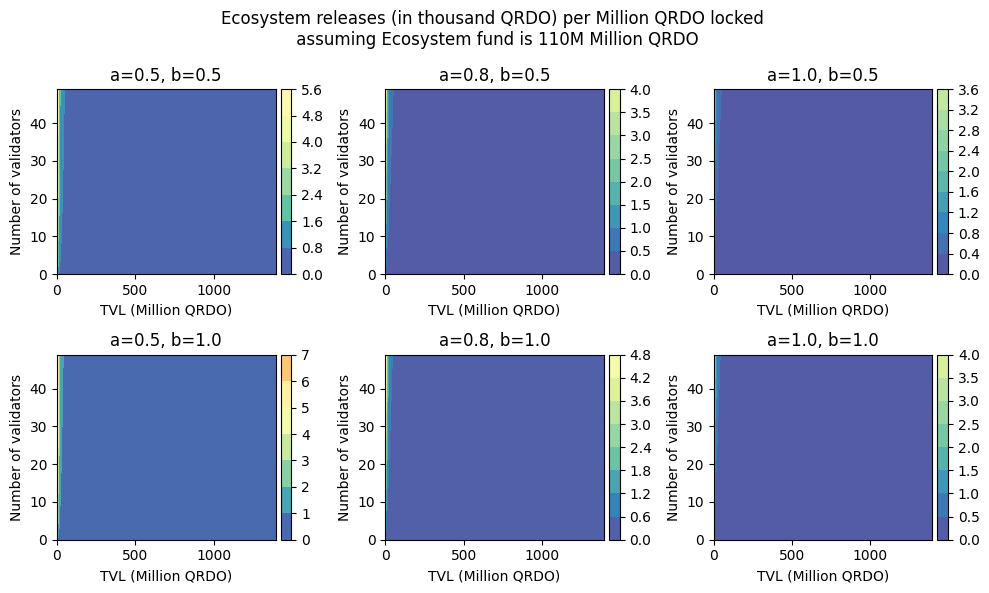

In [26]:
fig, axs = plt.subplots(2, 3, figsize=(10,6))
for col, a in enumerate(a_list):
    for row, b in enumerate(b_list):
        zz = (fractional_power(xx, yy, a, b, 8) * 110_000) / xx
        p = axs[row, col].contourf(x, y, zz, vmin=0, vmax=10, cmap="Spectral_r")
        divider = make_axes_locatable(axs[row, col])
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(p, cax=cax, orientation='vertical')
        axs[row, col].set_ylabel('Number of validators')
        axs[row, col].set_xlabel('TVL (Million QRDO)')
        axs[row, col].set_title(f'a={np.round(a, 1)}, b={b}')
plt.suptitle('Ecosystem releases (in thousand QRDO) per Million QRDO locked \n assuming Ecosystem fund is 110M Million QRDO')
plt.tight_layout()
plt.show()